In [7]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import warnings
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
random_seed=75
import load_lstm as lstm_istb4
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.options.mode.chained_assignment = None 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
# rc.rcParams['font.size'] = 12
rc('text', usetex=True)

In [8]:
"'load data'"
df = pd.read_csv('D:/istb_4/ISTB4_fillcombdata2.csv')
df_y = df['Chlorine.ppm.']
df_x =df[['pH','Conductivity.uS.',	'Temperature.C.','ORP.mV.','ISTB4.Sum']]#,'time_index

In [9]:

window_size=60
 # one step ahead of time
data_point=(int((len(df_x)-96)/window_size)-1)*window_size

In [10]:
Cl_x=df_x.iloc[:data_point,:]
Cl_y=df_y.to_numpy().reshape((-1, 1))#.iloc[:data_point+window_size_y]
Cl_y.shape,Cl_x.shape

((73504, 1), (73320, 5))

In [11]:
X1=np.array([Cl_x[i:i+window_size] for i in range (0,Cl_x.shape[0],window_size)])


In [12]:
"'LSTM MODEL PARAMETER'"
para_dict = {
  "learning_rate":5.00E-05,
    "train_episodes":5000,
    "batch_size":256,
    'drop_out':0,
    "random_seed":random_seed
}

In [13]:
step_list=list(range(0,96,12))
step_list[0]=1
tr_r2=[]
te_r2=[]
cv_r2=[]
tr_mse=[]
te_mse=[]
cv_mse=[]

for i in step_list:
    window_size_y=i
    y1 =np.array([Cl_y[i+window_size_y:i+window_size+window_size_y] for i in range (0,Cl_x.shape[0],window_size)])
    X_trcv, X_te,y_trcv,y_te=train_test_split(X1,y1,test_size=0.2, random_state=random_seed)
    X_tr, X_cv,y_tr,y_cv=train_test_split(X_trcv,y_trcv,test_size=0.2, random_state=random_seed)
    X_train = lstm_istb4.norm(X_tr,X_tr,window_size)
    X_val = lstm_istb4.norm(X_cv,X_tr,window_size)
    X_test = lstm_istb4.norm(X_te,X_tr,window_size)
    tensor_x_tr= torch.from_numpy(np.asarray(X_tr).astype(np.float32)).to(device)
    tensor_x_cv= torch.from_numpy(np.asarray(X_cv).astype(np.float32)).to(device)
    tensor_x_te= torch.from_numpy(np.asarray(X_te).astype(np.float32)).to(device)

    tensor_y_tr=torch.tensor(np.asarray(y_tr).squeeze(),dtype=torch.float).to(device)
    tensor_y_cv=torch.tensor(np.asarray(y_cv).squeeze(),dtype=torch.float).to(device)
    tensor_y_te=torch.tensor(np.asarray( y_te).squeeze(),dtype=torch.float).to(device)
    _,_,mv_net=lstm_istb4.train_validation_lstm(para_dict,device,tensor_x_tr,tensor_y_tr,tensor_x_cv,tensor_y_cv)
    output_tr=mv_net(tensor_x_tr)
    mv_net.eval()
    tr_pre=output_tr.cpu().detach().numpy().flatten()
    tr_insitu=tensor_y_tr.cpu().detach().numpy().flatten()
    
    tr_mse.append(mean_squared_error (tr_insitu,tr_pre))
    tr_r2.append(r2_score(tr_insitu,tr_pre))
    
    output_te=mv_net(tensor_x_te)
    te_pre=output_te.cpu().detach().numpy().flatten()
    te_insitu=tensor_y_te.cpu().detach().numpy().flatten()
    
    te_mse.append(mean_squared_error (te_insitu,te_pre))
    te_r2.append(r2_score(te_insitu,te_pre))
    
    output_cv=mv_net(tensor_x_cv)
    cv_pre=output_cv.cpu().detach().numpy().flatten()
    cv_insitu=tensor_y_cv.cpu().detach().numpy().flatten()
    
    cv_mse.append(mean_squared_error (cv_insitu,cv_pre))
    cv_r2.append(r2_score(cv_insitu,cv_pre))

In [ ]:
np.save('D:/istb_4/LSTM/step_ahead_random_shuffle_mse_tr_list_8hr_60window.npy',tr_mse)
np.save('D:/istb_4/LSTM/step_ahead_random_shuffle_mse_te_list_8hr_60window.npy',te_mse)
np.save('D:/istb_4/LSTM/step_ahead_random_shuffle_mse_cv_list_8hr_60window.npy',cv_mse)
np.save('D:/istb_4/LSTM/step_ahead_random_shuffle_r2_te_list_8hr_60window.npy',te_r2)
np.save('D:/istb_4/LSTM/step_ahead_random_shuffle_r2_tr_list_8hr_60window.npy',tr_r2)
np.save('D:/istb_4/LSTM/step_ahead_random_shuffle_r2_cv_list_8hr_60window.npy',cv_r2)

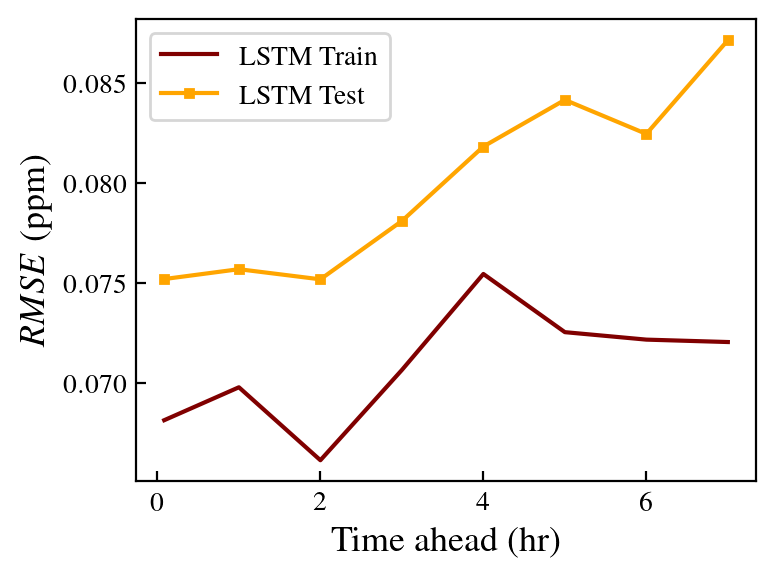

In [16]:
txt_size=13
label_size=10
fig, ax=plt.subplots(nrows=1, ncols=1, sharey= True, figsize=(4,3), dpi=200)
ax.plot(np.array(step_list)*5/60,np.array(tr_mse)**0.5, 'maroon', markersize=3,label='LSTM Train')
ax.plot(np.array(step_list)*5/60,np.array(te_mse)**0.5,'orange', marker='s', markersize=3,label='LSTM Test')
# ax.set_ylim([80,100])
ax.legend()
ax.set_xlabel('Time ahead (hr)',fontsize=txt_size)
ax.set_ylabel('$RMSE$ (ppm) ',fontsize=txt_size)
ax.tick_params(axis='both', direction='in',labelsize=label_size) 
plt.show()

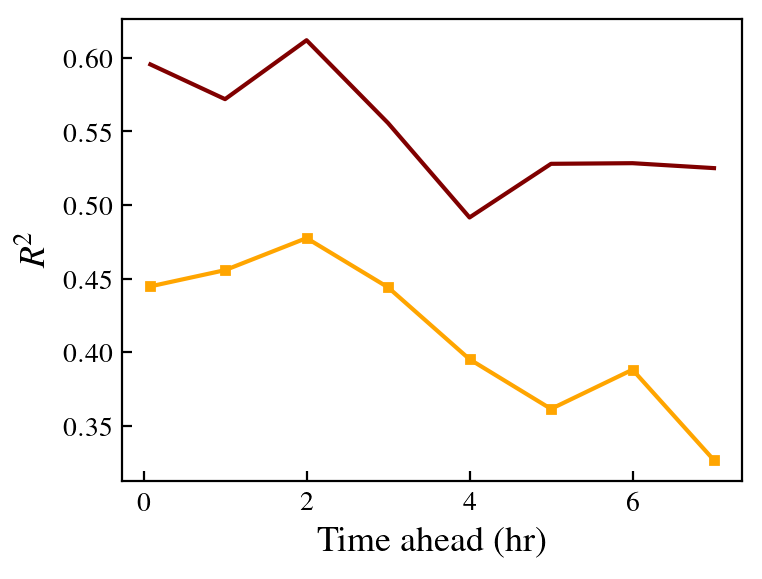

In [17]:

txt_size=13
label_size=10
fig, ax=plt.subplots(nrows=1, ncols=1, sharey= True, figsize=(4,3), dpi=200)
ax.plot(np.array(step_list)*5/60,tr_r2, 'maroon',markersize=3,label='Train')
ax.plot(np.array(step_list)*5/60,te_r2,'orange', marker='s', markersize=3,label='Test')
# ax.set_ylim([80,100])
# ax.legend()
ax.set_xlabel('Time ahead (hr)',fontsize=txt_size)
ax.set_ylabel('$R^2$ ',fontsize=txt_size)
ax.tick_params(axis='both', direction='in',labelsize=label_size) 
plt.show()